<a href="https://colab.research.google.com/github/sai-darshan-k/LLM/blob/main/2348548_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install accelerate peft bitsandbytes git+https://github.com/huggingface/transformers trl py7zr auto-gptq optimum

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-c7yqw3hd
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-c7yqw3hd
  Resolved https://github.com/huggingface/transformers to commit 8df28bb308e5676ad92eebafec2c4f2c3ebe5f31
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.7/424.7

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, AutoPeftModelForCausalLM, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, TrainingArguments
from trl import SFTTrainer
import os

data = load_dataset("tatsu-lab/alpaca", split="train")
data_df = data.to_pandas()
data_df = data_df[:5000]
data_df["text"] = data_df[["input", "instruction", "output"]].apply(lambda x: "###Human: " + x["instruction"] + " " + x["input"] + " ###Assistant: "+ x["output"], axis=1)
data = Dataset.from_pandas(data_df)


tokenizer = AutoTokenizer.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.1-GPTQ")
tokenizer.pad_token = tokenizer.eos_token


quantization_config_loading = GPTQConfig(bits=4, disable_exllama=True, tokenizer=tokenizer)
model = AutoModelForCausalLM.from_pretrained(
                            "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ",
                            quantization_config=quantization_config_loading,
                            device_map="auto"
                        )


model.config.use_cache=False
model.config.pretraining_tp=1
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)


peft_config = LoraConfig(
    r=16, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM", target_modules=["q_proj", "v_proj"]
)
model = get_peft_model(model, peft_config)


training_arguments = TrainingArguments(
        output_dir="mistral-finetuned-alpaca",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        optim="paged_adamw_32bit",
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="epoch",
        logging_steps=100,
        num_train_epochs=1,
        max_steps=250,
        fp16=True,
        push_to_hub=True
)


trainer = SFTTrainer(
        model=model,
        train_dataset=data,
        peft_config=peft_config,
        dataset_text_field="text",
        args=training_arguments,
        tokenizer=tokenizer,
        packing=False,
        max_seq_length=512
)


trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.


config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.However, loading attributes (e.g. ['use_cuda_fp16', 'use_exllama', 'max_input_length', 'exllama_config', 'disable_exllama']) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4568: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:408: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
100,1.429400
200,1.262900


TrainOutput(global_step=250, training_loss=1.3213354797363281, metrics={'train_runtime': 1486.7264, 'train_samples_per_second': 1.345, 'train_steps_per_second': 0.168, 'total_flos': 311794752946176.0, 'train_loss': 1.3213354797363281, 'epoch': 0.4})

In [ ]:
! cp -r /content/mistral-finetuned-alpaca /content/drive/MyDrive/

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import GenerationConfig
from transformers import AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("/content/mistral-finetuned-alpaca")

inputs = tokenizer("""Human: What is difference between Decriminative AI and Generative AI? """, return_tensors="pt").to("cuda")

In [ ]:
model = AutoPeftModelForCausalLM.from_pretrained(
    "/content/mistral-finetuned-alpaca",
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cuda")

In [ ]:
generation_config = GenerationConfig(
    do_sample=True,
    top_k=1,
    temperature=0.1,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id
)

In [ ]:
import time
st_time = time.time()
outputs = model.generate(**inputs, generation_config=generation_config)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
print(time.time()-st_time)

Human: What is difference between Decriminative AI and Generative AI? 
AI: Decriminative AI is a type of AI that is designed to make predictions or decisions based on data. It is used to identify patterns and make predictions based on those patterns. Generative AI, on the other hand, is a type of AI that is designed to generate new content or ideas. It is used to create new ideas or generate new content based on existing data.
89.225088596344


## Prompt1: Christ University is?

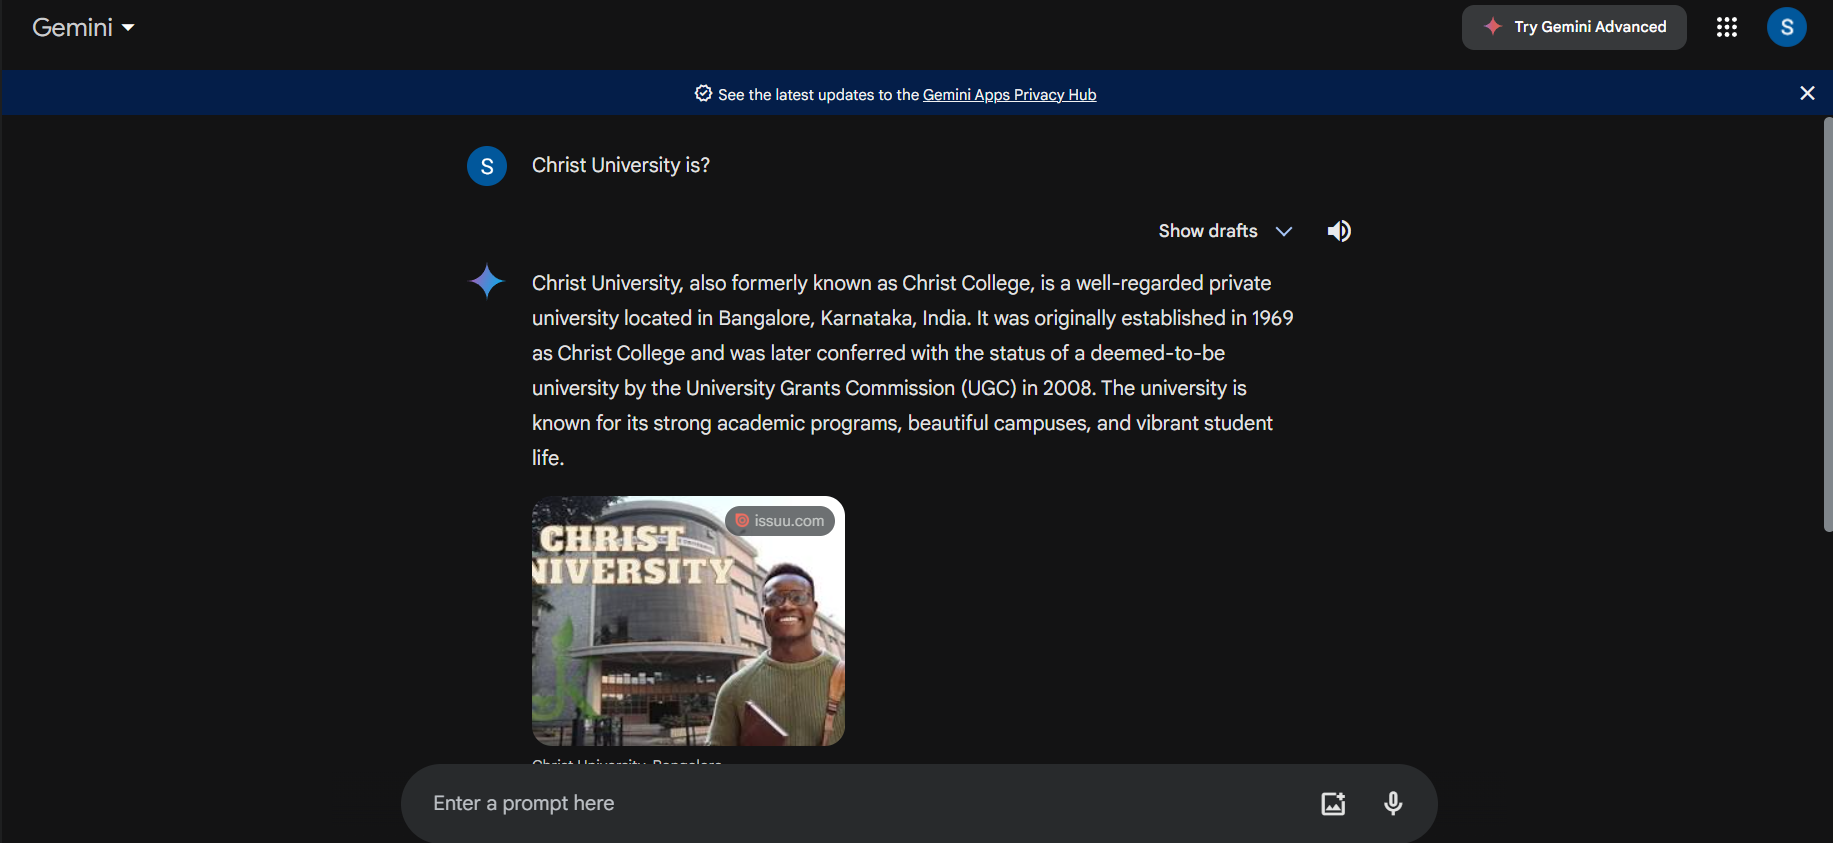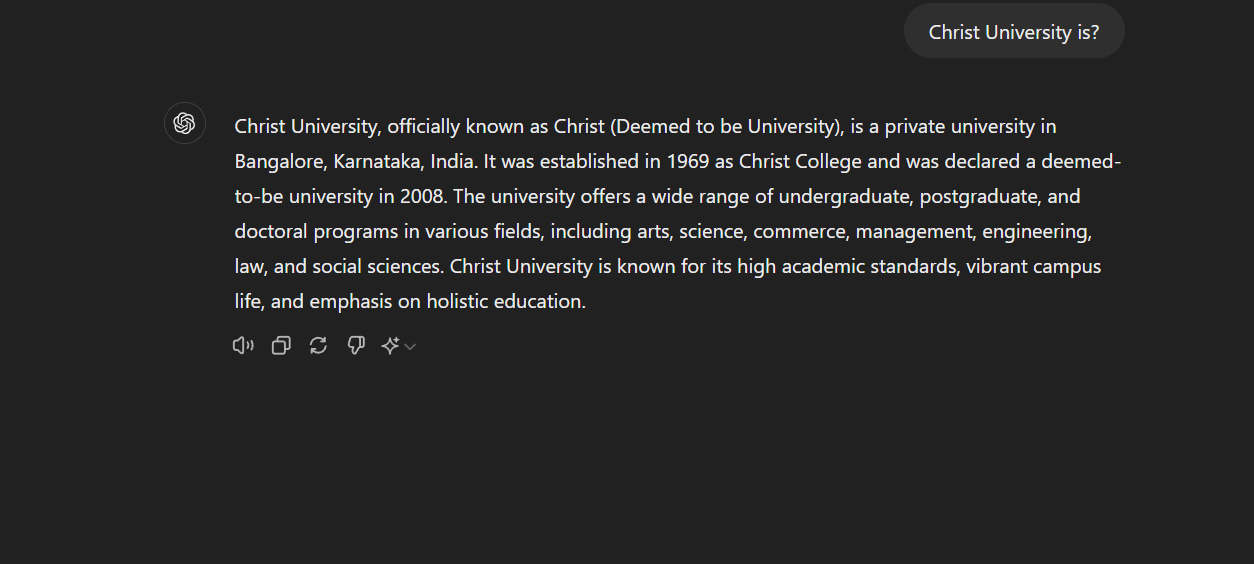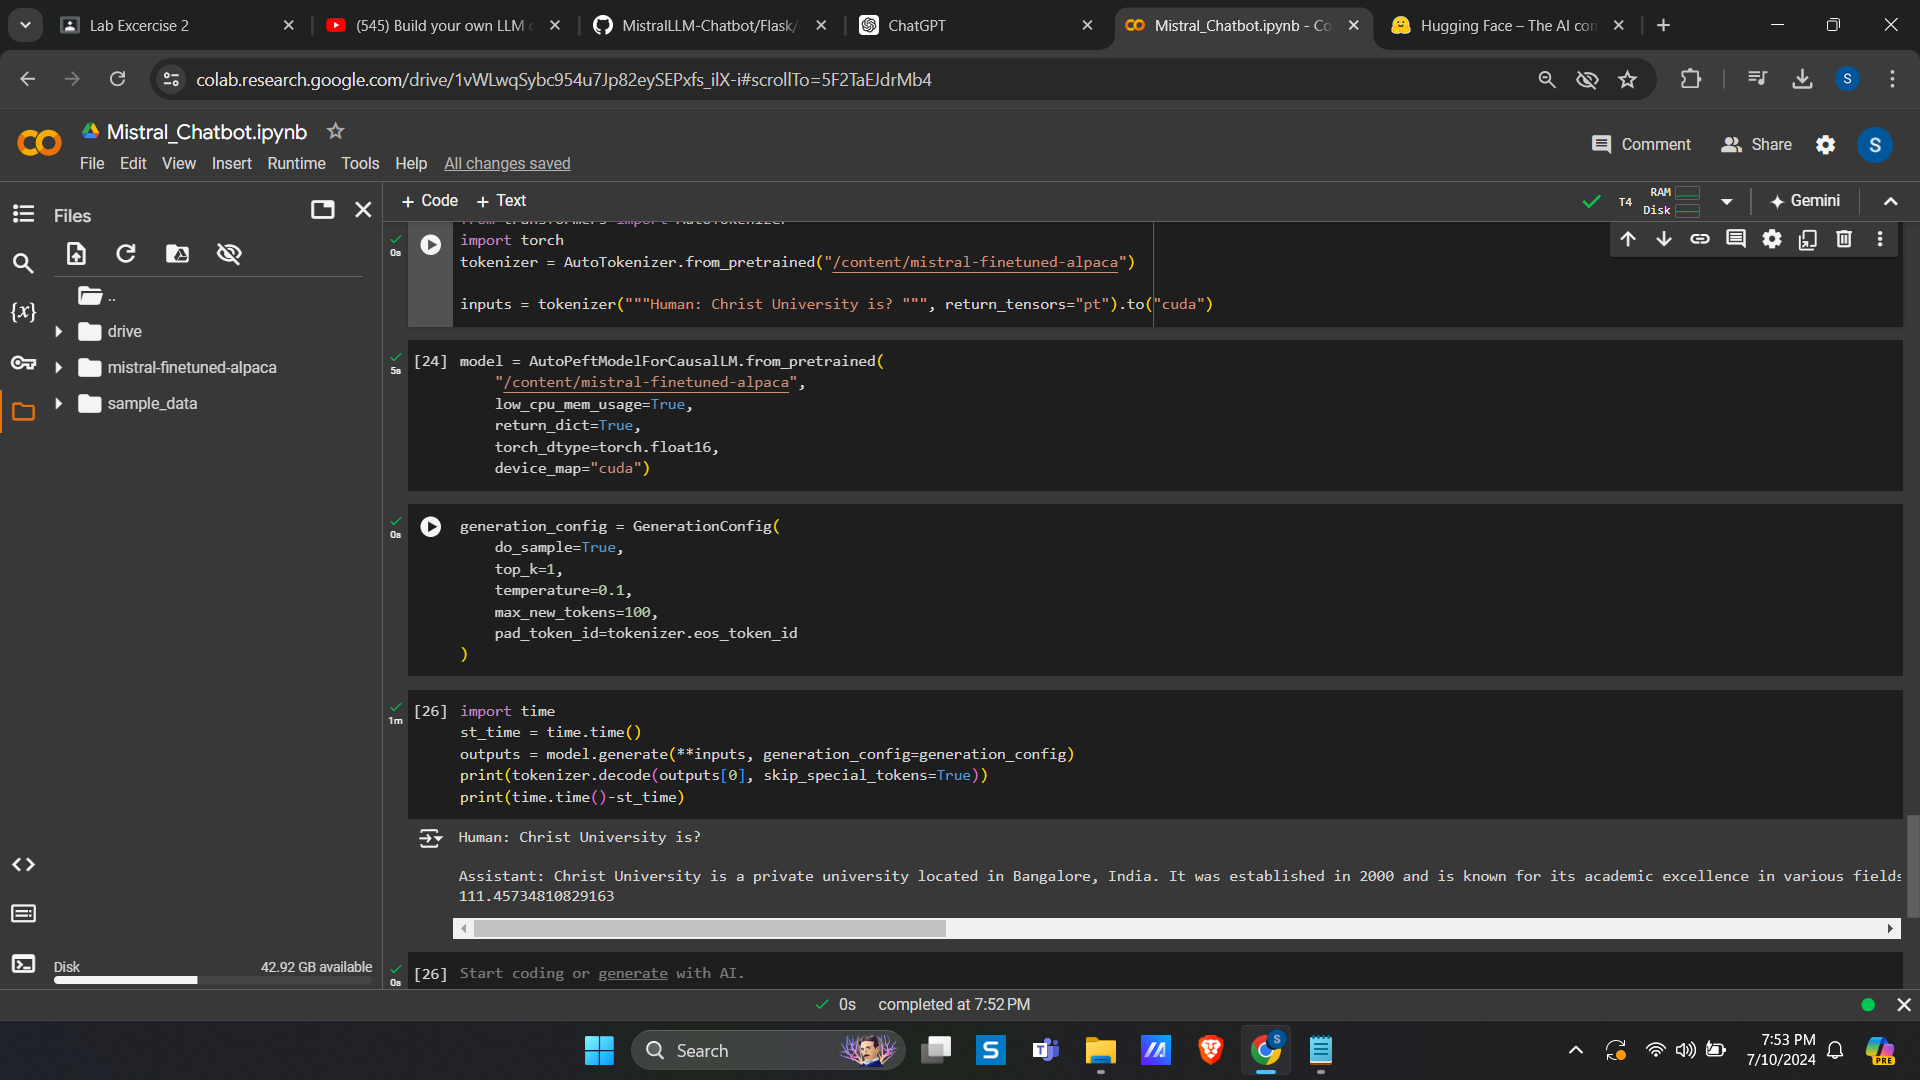

## Prompt2: Provide steps to prepare Gulab Jamun

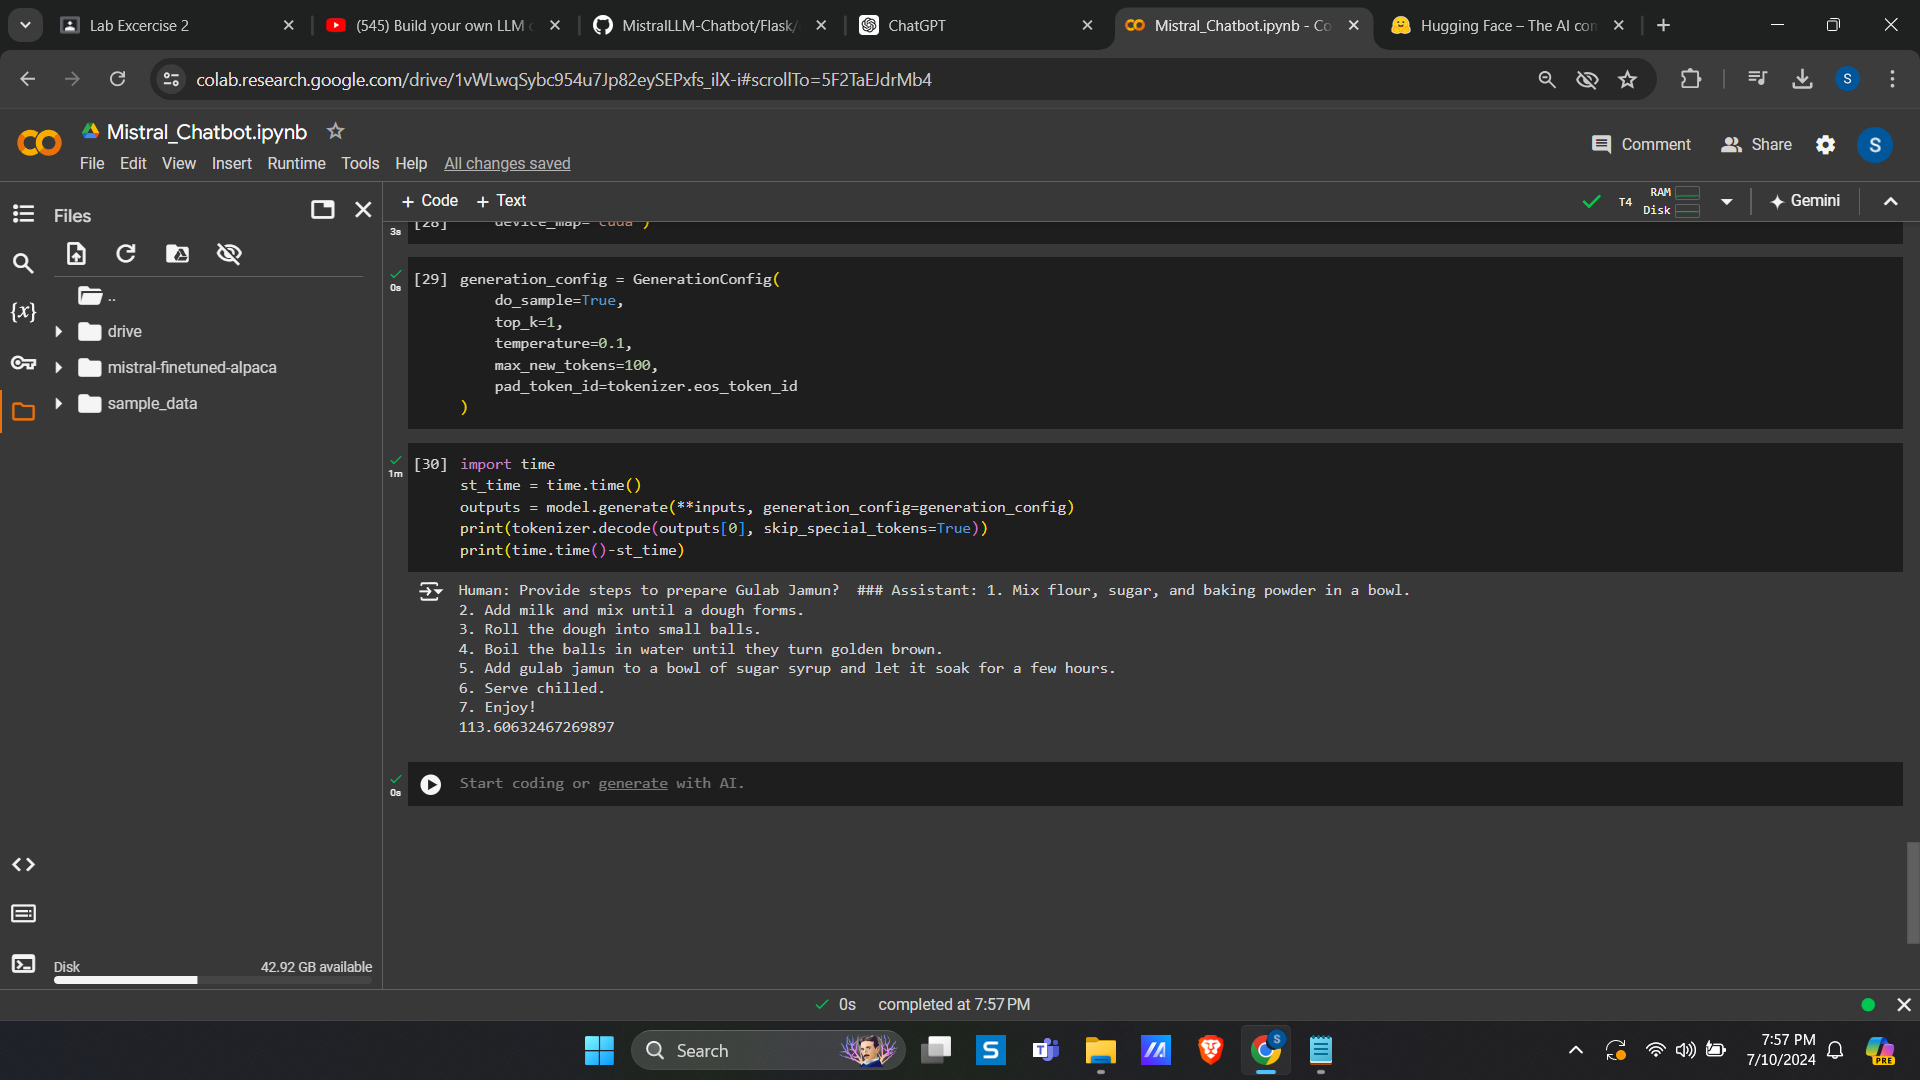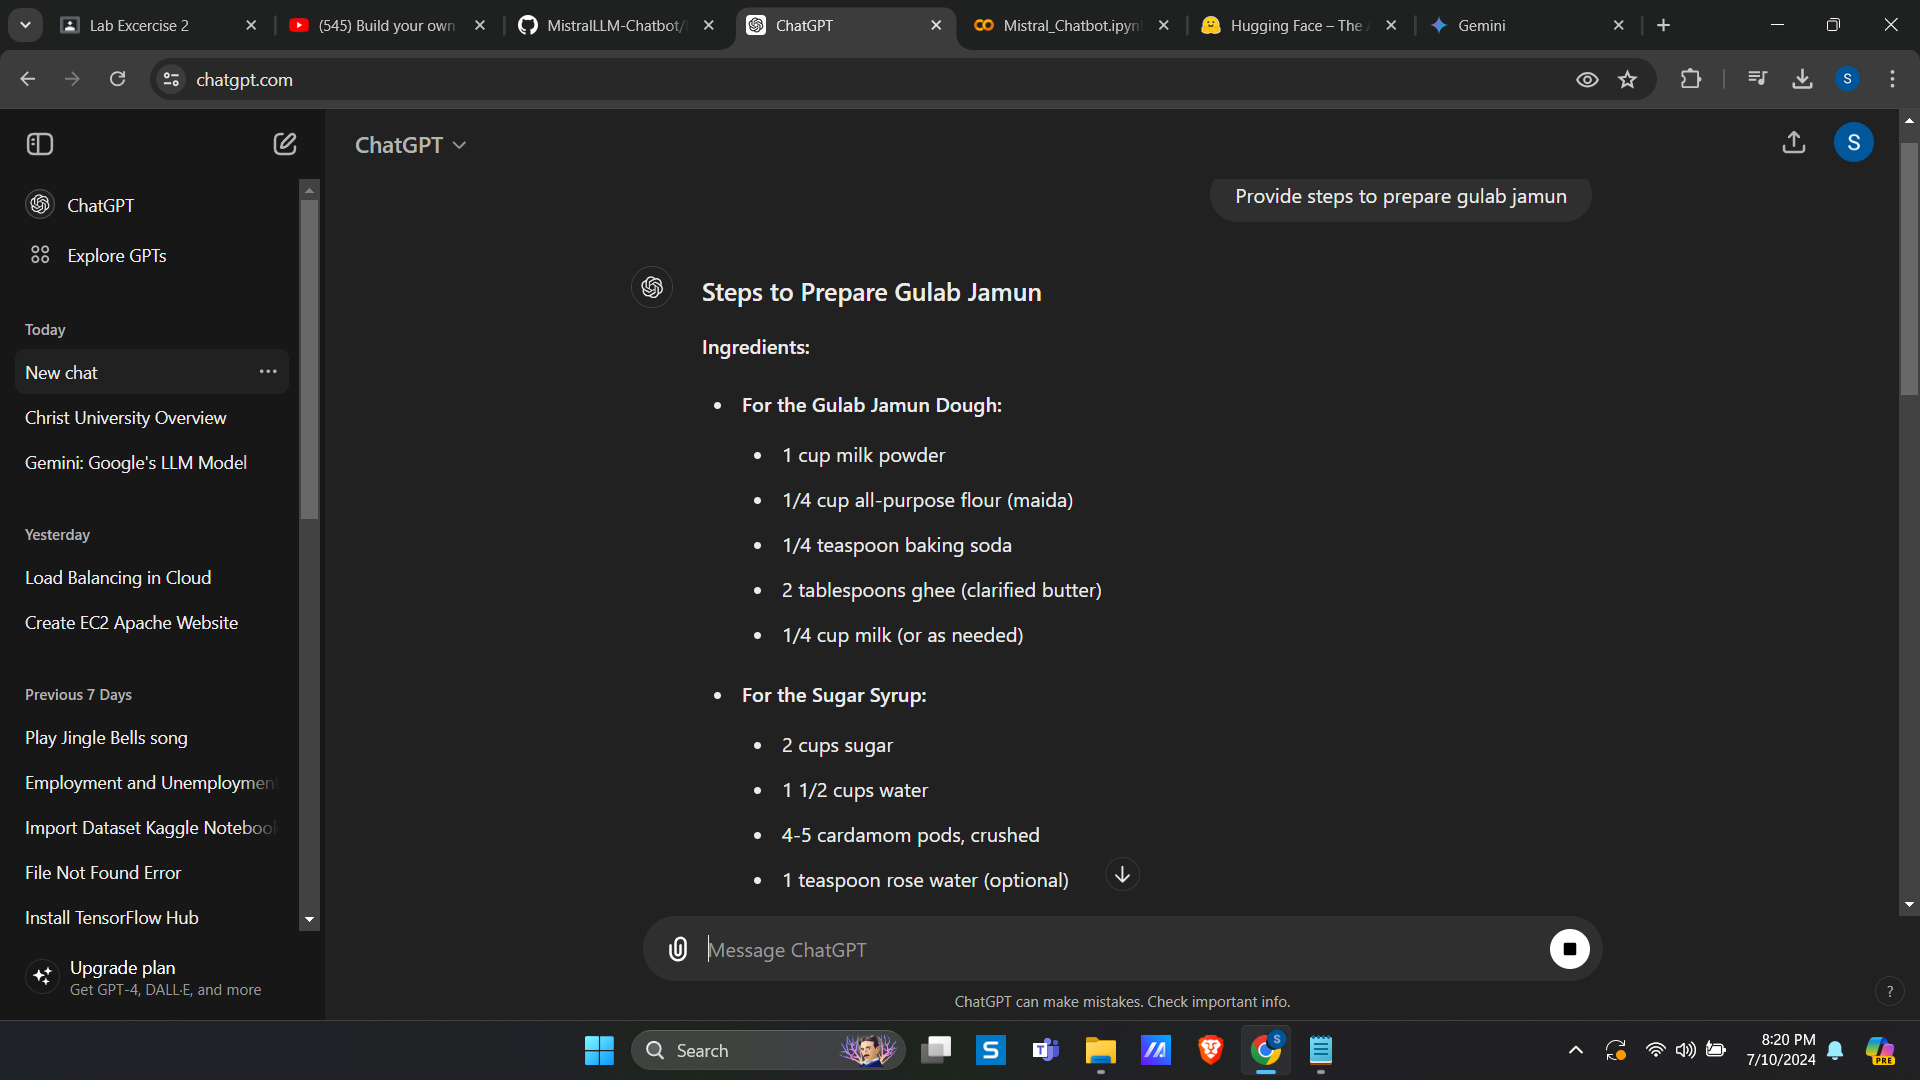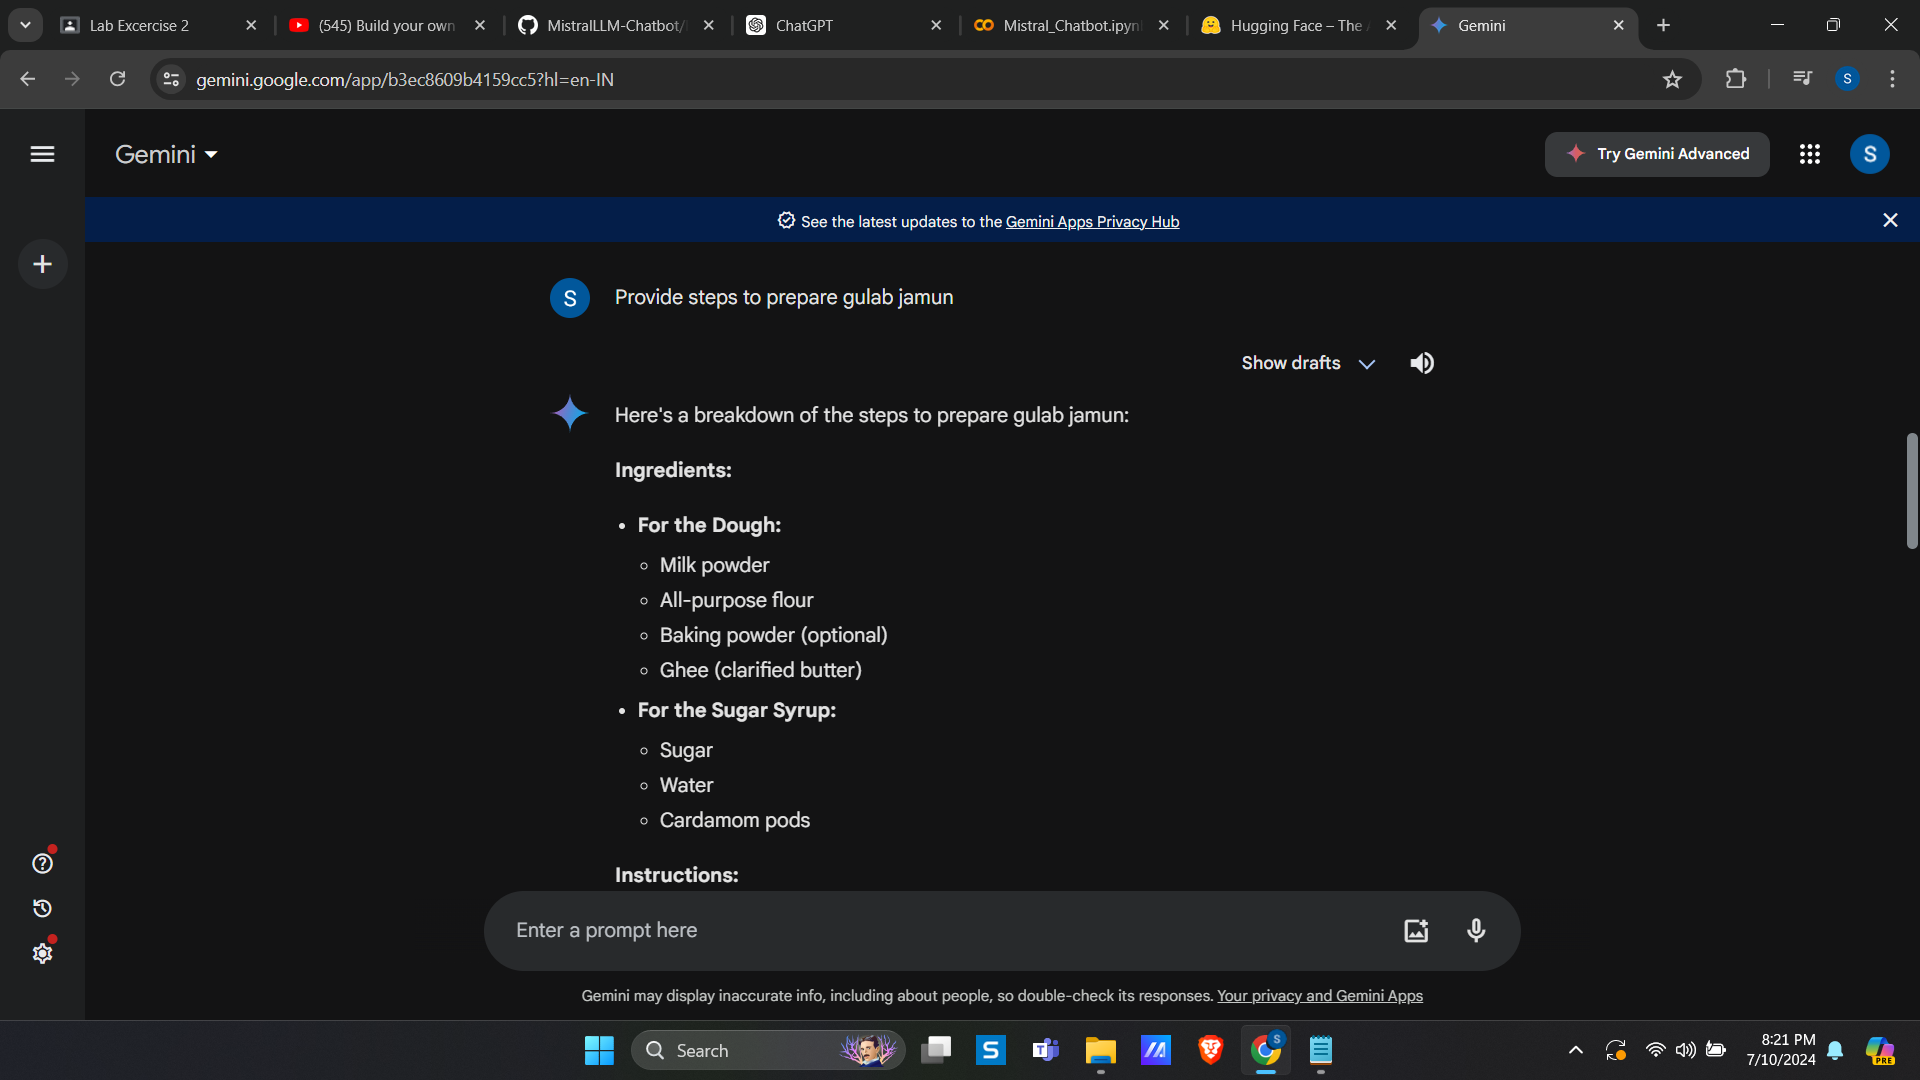

## Prompt3: What is difference between Decriminative AI and Generative AI?

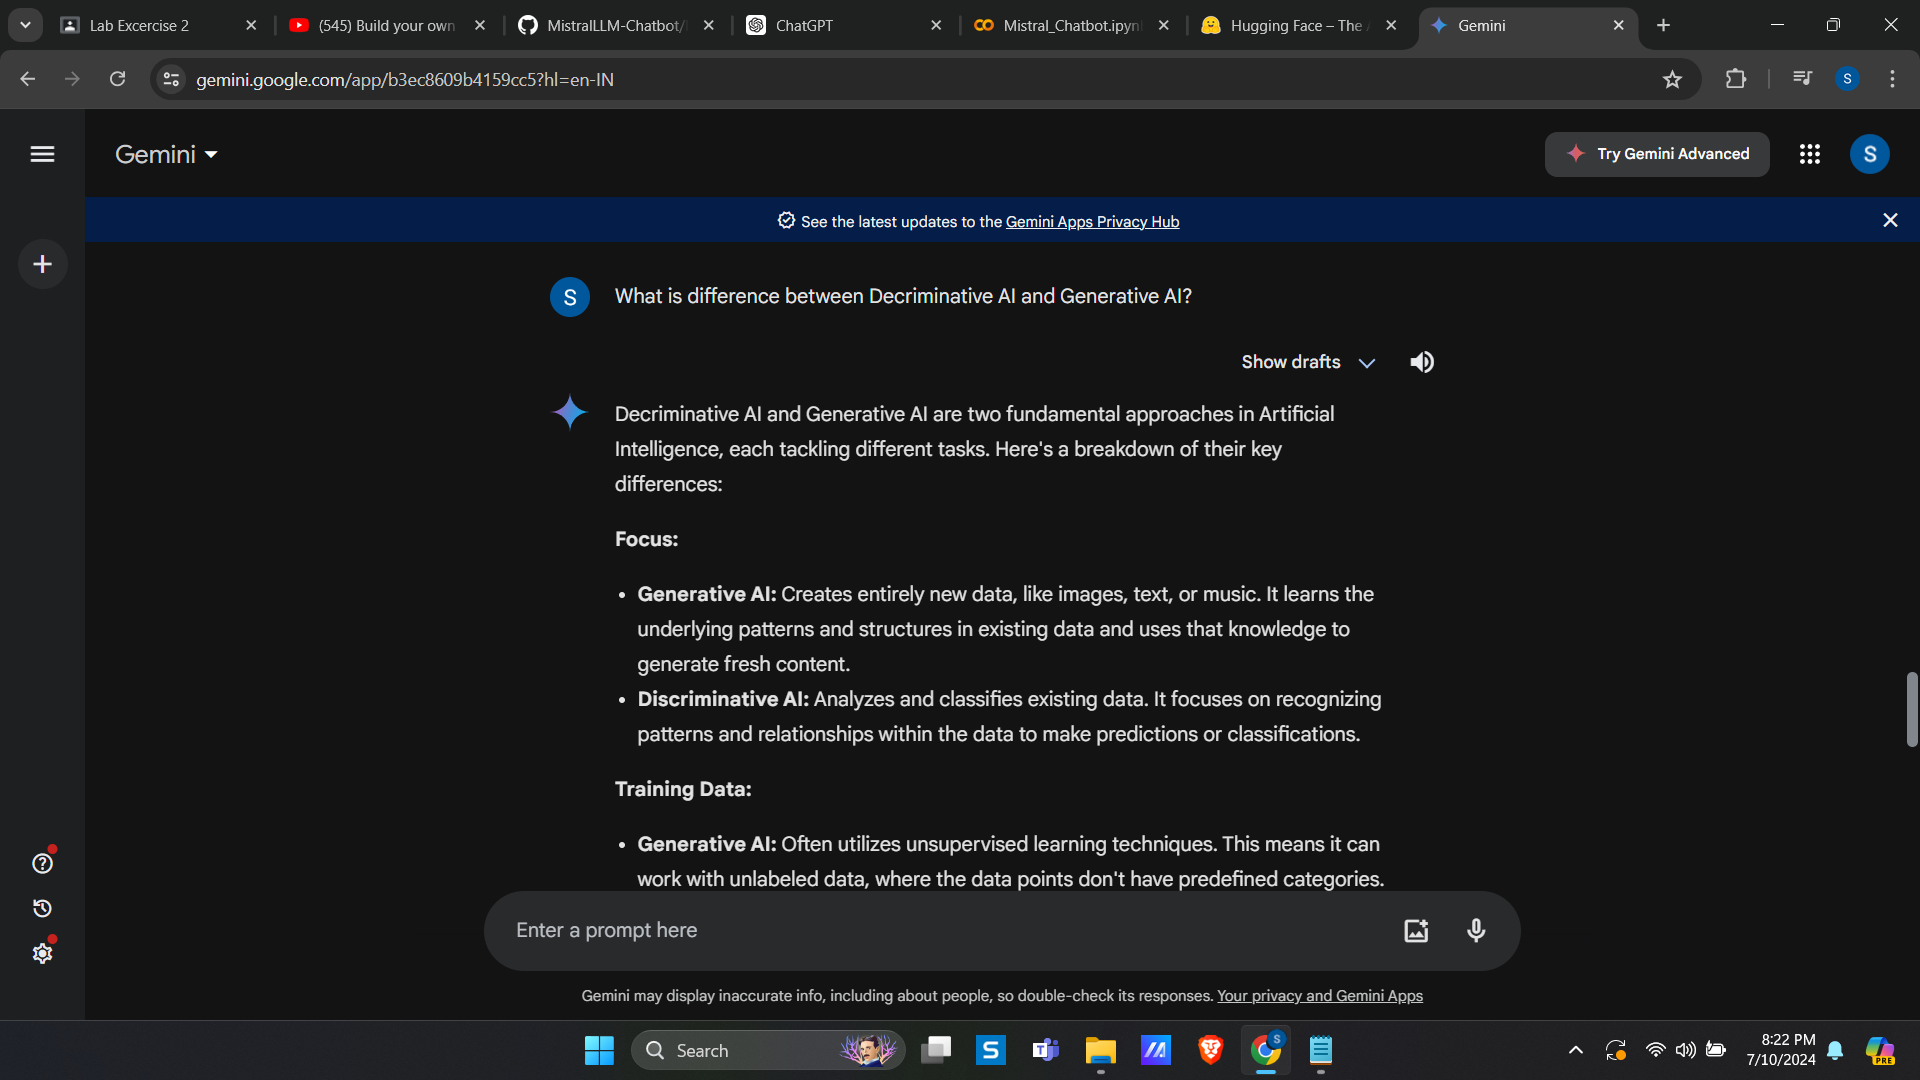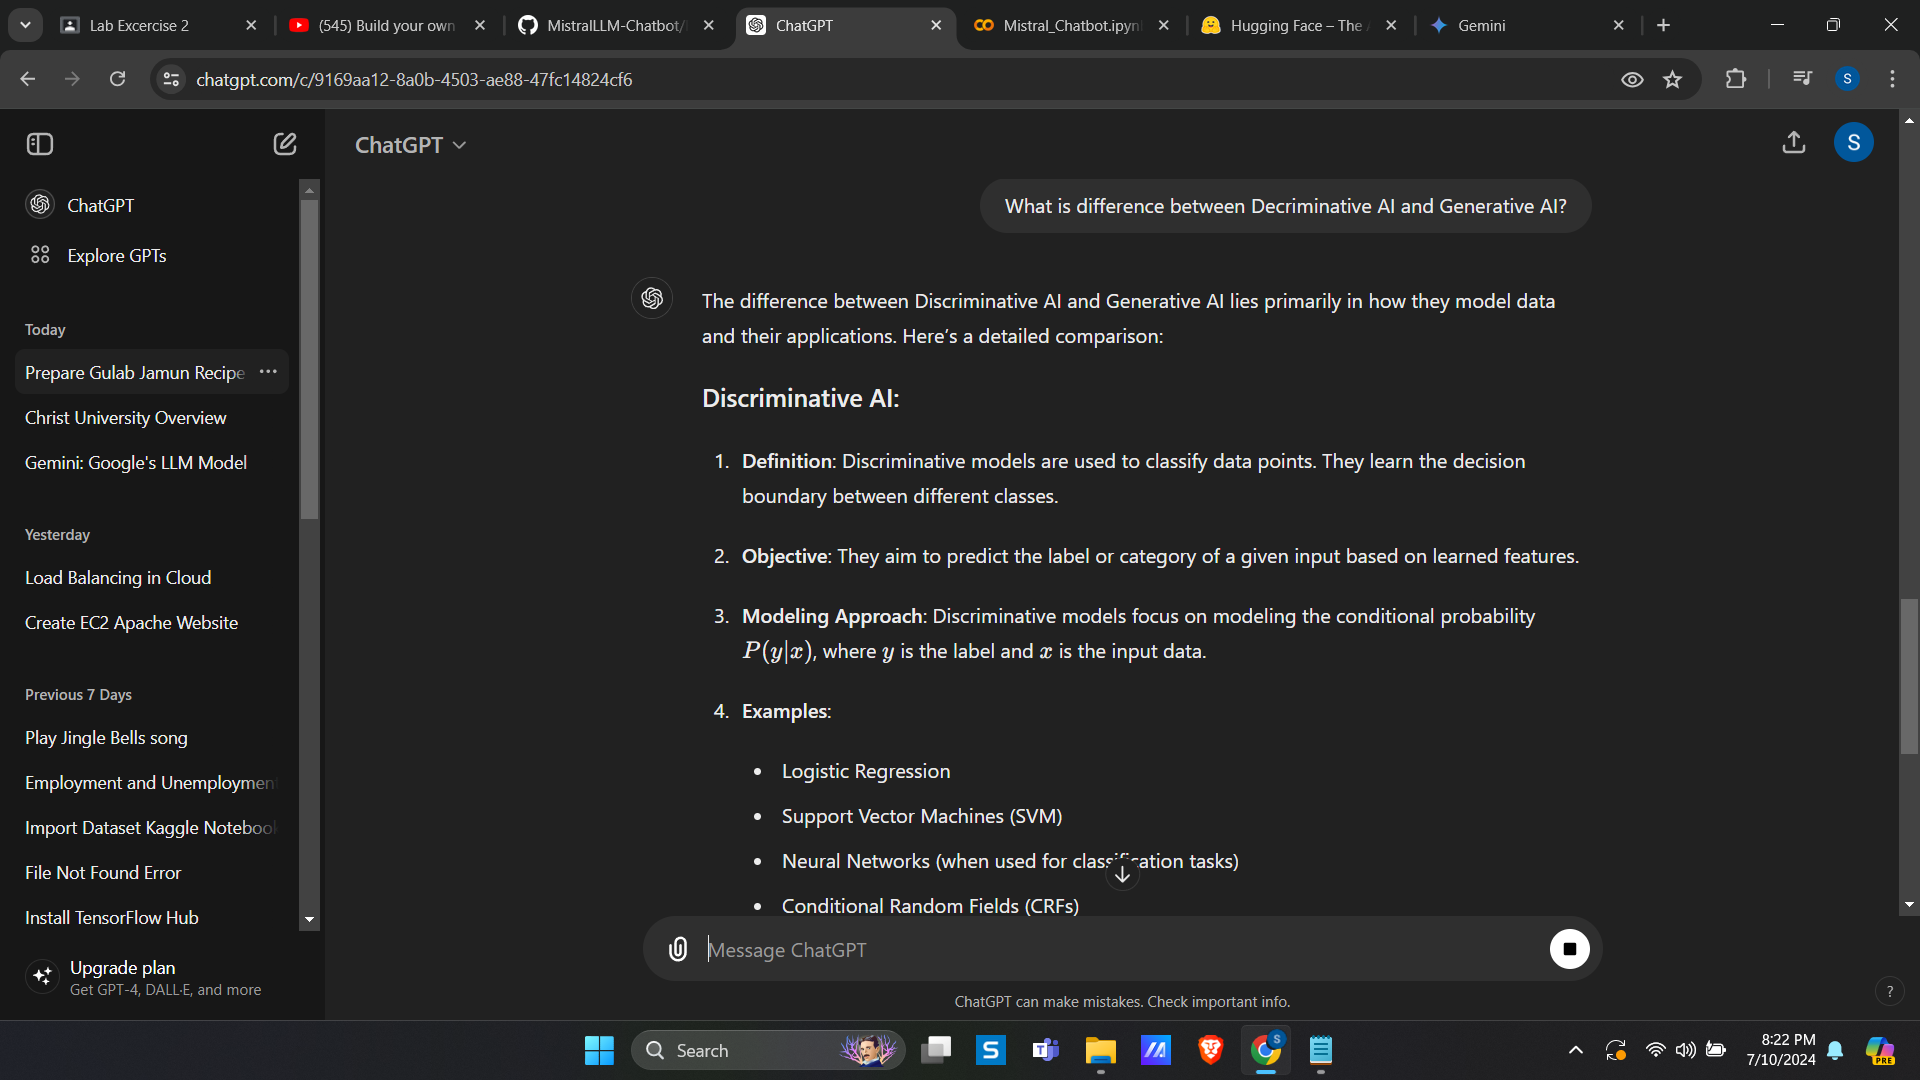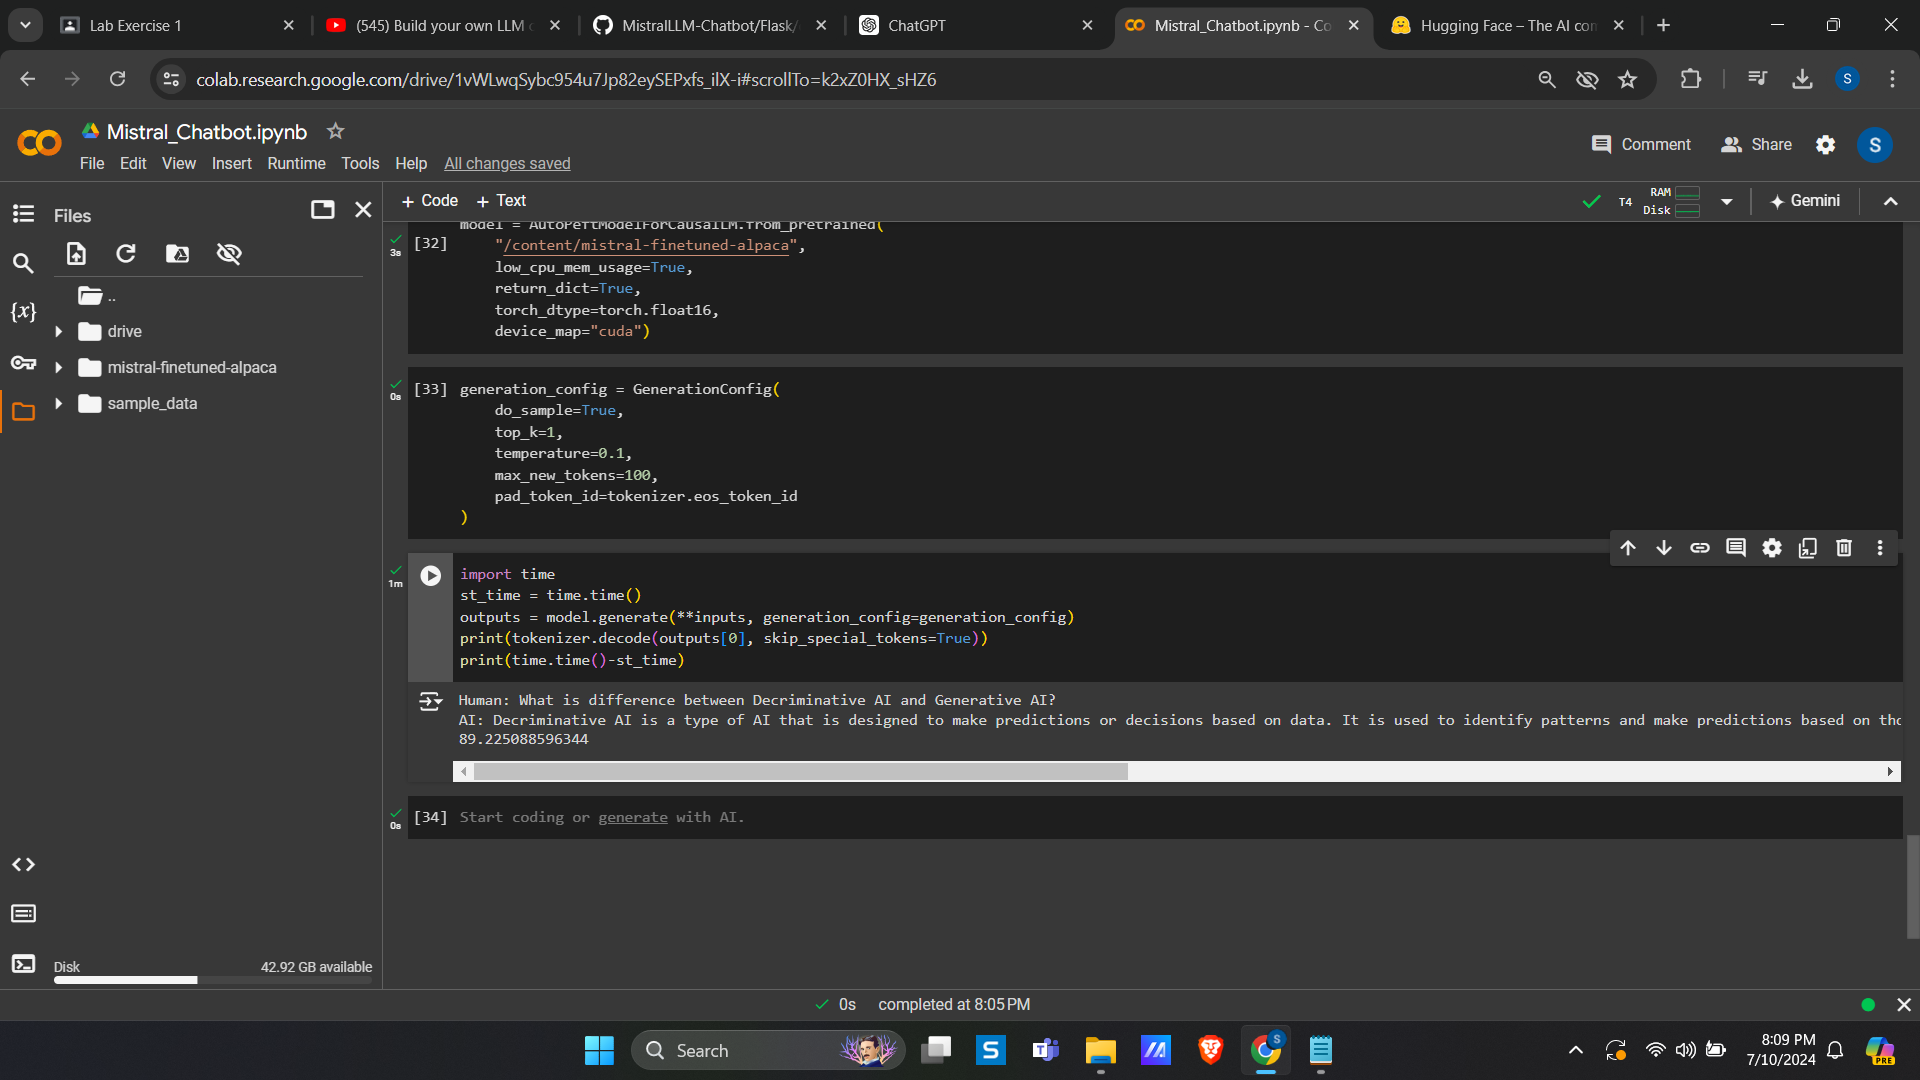